# AML Homework 3: Practice


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques. 


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model. 
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F


# fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [2]:
def create_model():
    """
    Create a simple CNN model for CIFAR10 dataset
    """

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),
        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        nn.Linear(32, 10),
    )

    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [3]:
import numpy as np
from torchvision import datasets, transforms

# Load the dataset
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

"""
Add your code below
"""
# Compute the mean and standard deviation for each channel
mean = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std = train_dataset.data.std(axis=(0, 1, 2)) / 255

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  [0.4914 0.4822 0.4465]
Std:  [0.247  0.2435 0.2616]


In [4]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean, std),  # Normalize the image channel
    ]
)

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(
    root="data", train=True, transform=cifar_transforms, download=True
)
test_dataset = datasets.CIFAR10(
    root="data", train=False, transform=cifar_transforms, download=True
)

# split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 1.3 See the data

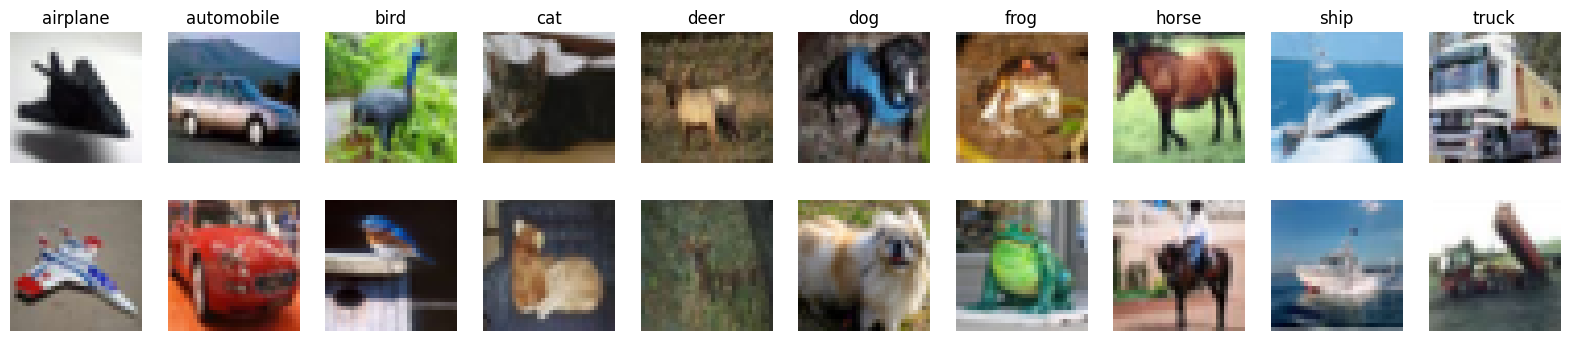

In [6]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[
        train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)
    ]
    axs[1, i].imshow(img)
    axs[1, i].axis("off")

### 1.4: Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load weights
model = create_model()
model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
model.to(device)

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)
num_epochs = 20

/tmp/ipykernel_49322/939893080.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
/home/dario/repos/unlear

In [ ]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    train_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = train_loss / len(train_loader)
    losses.append(avg_loss)

    # scheduler
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")

Epoch [1/20]: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s, loss=1.6] 


Epoch [1/20], Average Loss: 1.9016
Validation Loss: 1.6066


Epoch [2/20]: 100%|██████████| 98/98 [00:14<00:00,  6.84it/s, loss=1.38]


Epoch [2/20], Average Loss: 1.4677
Validation Loss: 1.3398


Epoch [3/20]: 100%|██████████| 98/98 [00:14<00:00,  6.68it/s, loss=1.29]


Epoch [3/20], Average Loss: 1.3244
Validation Loss: 1.2220


Epoch [4/20]:  84%|████████▎ | 82/98 [00:12<00:02,  6.71it/s, loss=1.21]


KeyboardInterrupt: 

In [ ]:
# Plot the losses after training
# epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), losses_val, label="Val Loss")
plt.axvline(index_best + 1, color="r", linestyle="--", label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

NameError: name 'best_loss' is not defined

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A: The training curve shows a lot of fluctuations for the validation loss, which sometimes goes over the training loss. This indicates that the model is prone to overfitting the training data. To address this issue, we want to introduce further regularization. An approach we suggest is to use `Dropout2d` layers instead of regular `Dropout` in the convolutional feature extraction part of the network. The reasoning is that `Dropout` zeroes individual pixels of the output feature map, which does **not** zero the gradients of any filter (since the parameters are shared), by contrast, `Dropout2d` zeroes entire channels of the output feature map, which does zero the gradients of the filters. Making this change stabilizes the curves, as shown above.

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [7]:
# accuracy
def accuracy(model, loader):
    """
    Function to calculate the accuracy of the model on the test set
    """
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [8]:
# your model
model = create_model()
model.load_state_dict(torch.load("checkpoint/trained_model.pth"))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

/tmp/ipykernel_74370/2572199704.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/trained_model.pth"))


NameError: name 'device' is not defined

To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [11]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

/tmp/ipykernel_140615/2030750594.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_model.pth"))


Train accuracy: 86.3800
Test Accuracy: 80.9000


# Section 2: Unlearning 

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario, 
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned. 

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning 

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data. 
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [7]:
# train
"""
Add your code below
"""

airplane_mask = torch.Tensor(train_dataset.targets) == 0
indices_retain = torch.arange(len(train_dataset))[~airplane_mask]
indices_forget = torch.arange(len(train_dataset))[airplane_mask]

retain_dataset = torch.utils.data.Subset(train_dataset, indices_retain)
forget_dataset = torch.utils.data.Subset(train_dataset, indices_forget)
retain_loader = torch.utils.data.DataLoader(
    retain_dataset, batch_size=batch_size, shuffle=True
)
forget_loader = torch.utils.data.DataLoader(
    forget_dataset, batch_size=batch_size, shuffle=True
)

In [8]:
len(retain_dataset), len(forget_dataset)

(45000, 5000)

In [9]:
# validation
"""
Add your code below
"""

airplane_mask_val = torch.Tensor(val_dataset.dataset.targets) == 0
indices_retain_val = torch.arange(len(val_dataset.dataset))[~airplane_mask_val]
indices_forget_val = torch.arange(len(val_dataset.dataset))[airplane_mask_val]

retain_dataset_val = torch.utils.data.Subset(val_dataset.dataset, indices_retain_val)
forget_dataset_val = torch.utils.data.Subset(val_dataset.dataset, indices_forget_val)
retain_loader_val = torch.utils.data.DataLoader(
    retain_dataset_val, batch_size=batch_size, shuffle=False
)
forget_loader_val = torch.utils.data.DataLoader(
    forget_dataset_val, batch_size=batch_size, shuffle=False
)

In [10]:
# test
"""
Add your code below
"""

airplane_mask_test = torch.Tensor(test_dataset.dataset.targets) == 0
indices_retain_test = torch.arange(len(test_dataset.dataset))[~airplane_mask_test]
indices_forget_test = torch.arange(len(test_dataset.dataset))[airplane_mask_test]

retain_dataset_test = torch.utils.data.Subset(test_dataset.dataset, indices_retain_test)
forget_dataset_test = torch.utils.data.Subset(test_dataset.dataset, indices_forget_test)
retain_loader_test = torch.utils.data.DataLoader(
    retain_dataset_test, batch_size=batch_size, shuffle=True
)
forget_loader_test = torch.utils.data.DataLoader(
    forget_dataset_test, batch_size=batch_size, shuffle=True
)

### 2.2: Training Loop

In [ ]:
def unlearning(
    model,
    retain_loader,
    validation,
    epochs=5,
    criterion=criterion,
    optimizer=meta_optimizer,
    scheduler=scheduler,
):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        # avg loss
        avg_loss = loss_epoch / len(retain_loader)
        losses.append(avg_loss)
        # scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in retain_loader_val:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")

    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [ ]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3, verbose=True
)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(
    forget_model,
    retain_loader,
    val_loader,
    epochs=epochs,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
)

/tmp/ipykernel_79508/2205427393.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))
Epoch [1/10]: 100%|

Epoch [1/10], Average Loss: 0.5238
Validation Loss: 2.3022


Epoch [2/10]: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s, loss=0.493]


Epoch [2/10], Average Loss: 0.5040
Validation Loss: 2.2628


Epoch [3/10]: 100%|██████████| 88/88 [00:13<00:00,  6.53it/s, loss=0.514]


Epoch [3/10], Average Loss: 0.4947
Validation Loss: 2.2686


Epoch [4/10]: 100%|██████████| 88/88 [00:14<00:00,  6.18it/s, loss=0.445]


Epoch [4/10], Average Loss: 0.4922
Validation Loss: 2.2665


Epoch [5/10]: 100%|██████████| 88/88 [00:13<00:00,  6.50it/s, loss=0.495]


Epoch [5/10], Average Loss: 0.4948
Validation Loss: 2.2708


Epoch [6/10]: 100%|██████████| 88/88 [00:13<00:00,  6.48it/s, loss=0.504]


Epoch [6/10], Average Loss: 0.4870
Validation Loss: 2.2857


Epoch [7/10]: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s, loss=0.427]


Epoch [7/10], Average Loss: 0.4894
Validation Loss: 2.2804


Epoch [8/10]: 100%|██████████| 88/88 [00:13<00:00,  6.59it/s, loss=0.513]


Epoch [8/10], Average Loss: 0.4866
Validation Loss: 2.2205


Epoch [9/10]: 100%|██████████| 88/88 [00:13<00:00,  6.52it/s, loss=0.45] 


Epoch [9/10], Average Loss: 0.4828
Validation Loss: 2.2314


Epoch [10/10]: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s, loss=0.449]


Epoch [10/10], Average Loss: 0.4827
Validation Loss: 2.2511


/tmp/ipykernel_79508/3168067241.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/forget_model.pth"))


**Below there is the evaluation of your unlearned by fine-tuning model**

In [19]:
# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
forget_model.eval()
forget_model.to(device)

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")  # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

/tmp/ipykernel_79508/1275260100.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"))


Retain set Accuracy: 88.9133
Forget set Accuracy: 34.9600
Test set Accuracy: 77.8375
Test set Retain Accuracy: 83.2222
Test set Forget Accuracy: 28.7000


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A: Comparing the older model's accuracy computed before the unlearning process on the whole dataset to the one obtained after the unlearning on the retain dataset, we can assess that the model kept its performances on the retained classes while it lost the ability to perform well on airplanes, effectively suggesting that model forgot about that class.

These suppositions are confirmed by the results on the tests sets. In facts the overall peformances are lower than the previous ones, confirming that the model unlearned it. Since the retain accuracy is higher it means that it improved it's performances on the retained classes. By comparing the validation forget set accuracy and the test forget set accuracy we can say that the model is not generalizing on the airplanes, which is the expected behaviour.

even tho we could have logged the results on each class, so that we could really know if it unlearned airplanes or some other unexpected class.

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [20]:
for i, sample in enumerate(retain_loader):

    data, targets = sample
    if (targets == 0).any():
        print(i)
        break

In [ ]:
# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)
num_epochs = 20

/tmp/ipykernel_79508/1211376923.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))


#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [ ]:
# **IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    gold_model.train()
    train_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = gold_model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = train_loss / len(retain_loader)
    losses.append(avg_loss)

    # scheduler
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    gold_model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in retain_loader_val:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = gold_model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(retain_loader_val)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")

Epoch [1/20]: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s, loss=2.15]


Epoch [1/20], Average Loss: 2.2297
Validation Loss: 2.1531


Epoch [2/20]: 100%|██████████| 88/88 [00:12<00:00,  6.79it/s, loss=2.03]


Epoch [2/20], Average Loss: 2.0952
Validation Loss: 2.0204


Epoch [3/20]: 100%|██████████| 88/88 [00:13<00:00,  6.44it/s, loss=1.85]


Epoch [3/20], Average Loss: 1.9616
Validation Loss: 1.8809


Epoch [4/20]: 100%|██████████| 88/88 [00:13<00:00,  6.59it/s, loss=1.76]


Epoch [4/20], Average Loss: 1.8297
Validation Loss: 1.7592


Epoch [5/20]: 100%|██████████| 88/88 [00:13<00:00,  6.30it/s, loss=1.66]


Epoch [5/20], Average Loss: 1.7208
Validation Loss: 1.6500


Epoch [6/20]: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s, loss=1.57]


Epoch [6/20], Average Loss: 1.6262
Validation Loss: 1.5630


Epoch [7/20]: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s, loss=1.58]


Epoch [7/20], Average Loss: 1.5531
Validation Loss: 1.4845


Epoch [8/20]: 100%|██████████| 88/88 [00:13<00:00,  6.62it/s, loss=1.44]


Epoch [8/20], Average Loss: 1.4902
Validation Loss: 1.4244


Epoch [9/20]: 100%|██████████| 88/88 [00:13<00:00,  6.61it/s, loss=1.43]


Epoch [9/20], Average Loss: 1.4421
Validation Loss: 1.3767


Epoch [10/20]: 100%|██████████| 88/88 [00:13<00:00,  6.57it/s, loss=1.36]


Epoch [10/20], Average Loss: 1.3899
Validation Loss: 1.3233


Epoch [11/20]: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s, loss=1.28]


Epoch [11/20], Average Loss: 1.3564
Validation Loss: 1.2765


Epoch [12/20]: 100%|██████████| 88/88 [00:13<00:00,  6.40it/s, loss=1.33]


Epoch [12/20], Average Loss: 1.3180
Validation Loss: 1.2648


Epoch [13/20]: 100%|██████████| 88/88 [00:13<00:00,  6.53it/s, loss=1.37]


Epoch [13/20], Average Loss: 1.2928
Validation Loss: 1.2402


Epoch [14/20]: 100%|██████████| 88/88 [00:14<00:00,  6.24it/s, loss=1.24]


Epoch [14/20], Average Loss: 1.2663
Validation Loss: 1.1930


Epoch [15/20]: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s, loss=1.26]


Epoch [15/20], Average Loss: 1.2456
Validation Loss: 1.1767


Epoch [16/20]: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s, loss=1.2] 


Epoch [16/20], Average Loss: 1.2260
Validation Loss: 1.1515


Epoch [17/20]: 100%|██████████| 88/88 [00:13<00:00,  6.57it/s, loss=1.22]


Epoch [17/20], Average Loss: 1.2093
Validation Loss: 1.1553


Epoch [18/20]: 100%|██████████| 88/88 [00:14<00:00,  6.27it/s, loss=1.21]


Epoch [18/20], Average Loss: 1.1935
Validation Loss: 1.1210


Epoch [19/20]: 100%|██████████| 88/88 [00:12<00:00,  6.79it/s, loss=1.19]


Epoch [19/20], Average Loss: 1.1778
Validation Loss: 1.1087


Epoch [20/20]: 100%|██████████| 88/88 [00:13<00:00,  6.72it/s, loss=1.16]


Epoch [20/20], Average Loss: 1.1698
Validation Loss: 1.1105


Best validation loss: 1.1087


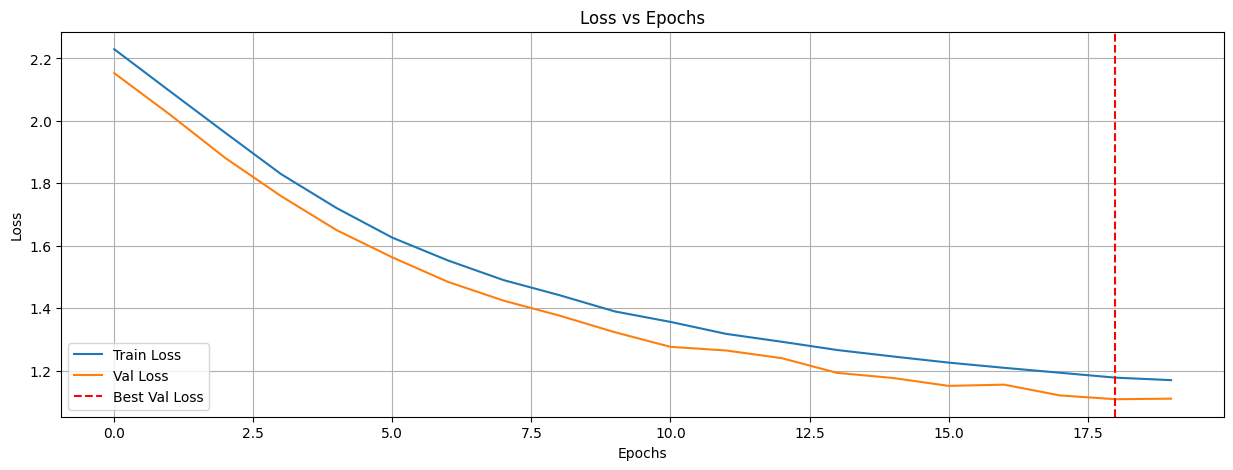

In [23]:
# epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color="r", linestyle="--", label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [24]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device)

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

/tmp/ipykernel_79508/1336622808.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))


Retain set Accuracy: 60.1267
Forget set Accuracy: 0.0000
Test set Accuracy: 53.4750
Test set Retain Accuracy: 59.7000
Test set Forget Accuracy: 0.0000


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: The accuracy on the forget set is 0 because the model never saw that class in the targets and during the learning process it was always discouradged to predict that class.

Something is strange since we would expect the gold model to be better than the one obtained using the unlearning process but instead it is a lot worse. Anyway to have more reliable results we should have compared the gold_model with the model obtained applying unlearning on the trained_model instead of the one obtained applying unlearning on the best_model because trained_model and gold_model are trained in the same way

# Section 5: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [25]:
def compute_losses(model, loader, criterion="CrossEntropy"):
    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = (
            nn.CrossEntropyLoss(reduction="none")(logits, targets)
            .detach()
            .cpu()
            .numpy()
        )

        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [26]:
# model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"))
model.eval()
model.to(device)

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)

/tmp/ipykernel_79508/165132113.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_model.pth"))


In [27]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
forget_model.eval()
forget_model.to(device)

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)

/tmp/ipykernel_79508/2927356677.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"))


In [28]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device)

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

/tmp/ipykernel_79508/2360865515.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))


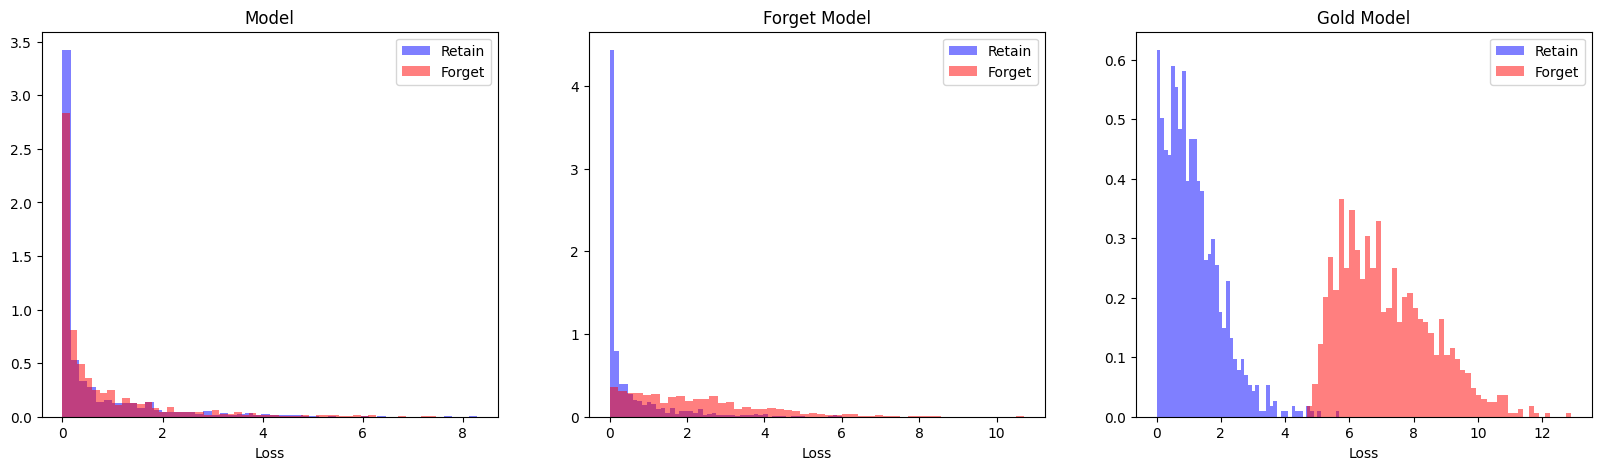

In [29]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(
    np.arange(len(retain_losses)), len(forget_losses), replace=False
)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(
    retain_losses, density=True, bins=50, alpha=0.5, label="Retain", color="blue"
)
axs[0].hist(
    forget_losses, density=True, bins=50, alpha=0.5, label="Forget", color="red"
)
axs[0].set_title("Model")
axs[0].set_xlabel("Loss")
axs[0].legend()

axs[1].hist(
    retain_losses_forget, density=True, bins=50, alpha=0.5, label="Retain", color="blue"
)
axs[1].hist(
    forget_losses_forget, density=True, bins=50, alpha=0.5, label="Forget", color="red"
)
axs[1].set_title("Forget Model")
axs[1].set_xlabel("Loss")
axs[1].legend()

axs[2].hist(
    retain_losses_gold, density=True, bins=50, alpha=0.5, label="Retain", color="blue"
)
axs[2].hist(
    forget_losses_gold, density=True, bins=50, alpha=0.5, label="Forget", color="red"
)
axs[2].set_title("Gold Model")
axs[2].set_xlabel("Loss")
axs[2].legend()

plt.show()

In [30]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    torch.manual_seed(torch.initial_seed())

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=0)

    return model_selection.cross_val_score(
        attack_model,
        sample_loss,
        members,
        cv=cv,
        scoring="accuracy",
    )

In [31]:
# mia on model
retain_losses_subsample = np.random.choice(
    retain_losses, len(forget_losses), replace=False
)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
# balance the number of samples
members_mia = np.concatenate(
    [np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))]
)

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5440


In [32]:
# mia on forget model
retain_losses_forget_subsample = np.random.choice(
    retain_losses_forget, len(forget_losses_forget), replace=False
)
samples_mia = np.concatenate(
    [retain_losses_forget_subsample, forget_losses_forget]
).reshape(-1, 1)
members_mia = np.concatenate(
    [np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))]
)

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.7610


In [33]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(
    retain_losses_gold, len(forget_losses_gold), replace=False
)
samples_mia = np.concatenate(
    [retain_losses_gold_subsample, forget_losses_gold]
).reshape(-1, 1)
members_mia = np.concatenate(
    [np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))]
)

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 0.9960


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A:


*   Model: This first model was trained on all the data ($\text{retain} \cup \text{forget}$).In our plot of the losses we can see that retain and forget data have a similar distribution and for both density is clustered on the lower values. The MIA attack returns a probability near to 50%, which means that the MIA model is not able to discriminate between forget and retain datasets based on the losses, indicating that probably all the data (forget and retain) were used during Model training
*   Forget Model: this model was produced by unlearning through fine-tuning the previous model. from the plot of losses we start to see a clear difference on the distribution of the losses for the 2 different sets. Retain data still has a density peak around the lower end of the loss values, instead, forget data has a more uniform loss distribution, with higher variance. The MIA score is around $\approx 70\%$, indicating some capacity of the MIA model to discern between the two datasets, but not in a perfect way. It is clear that the model retains some of the previous information about the forget dataset even after fine-tuning.
*   Gold Model: This model was trained *only* on retianed data, it is clear from the plot of the ownership probabilities over the losses that the distributions have an almost perfect separation. The ownership density's mean is lower for the retain data, as it was used to train the Gold Model, and higher for the forget data. The MIA score is around almost $100\%$ ($99.5\%$), meaning that the MIA model can now perfectly distinguish between the two datasets based on the losses.



# 6. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point) 

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: Kullback-Leiber dirvergence explicitly measures the distance between two distributions, whereas cross-entropy measures the average number of bits required to encode the true distribution using the predicted distribution. This means that, if the distributions are equal, in the case of KL divergence, the result will be 0, while in the case of cross-entropy, the result will be the entropy of the true distribution (which is always positive). Therefore, by using KL divergence with a uniform distribution target (which usually has high entropy), perfect unlearning will result in a KL divergence of 0.

In [11]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

"""
Add your code below
"""
cross_entropy = F.cross_entropy(y_pred, y_gt)
kl_div = F.kl_div(y_pred.log(), y_gt, reduction="batchmean")

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A: As stated before, Cross-Entropy measures the average number of bits required to encode the true distribution using the predicted distribution, whereas KL-divergence is a distance measure between two distributions. 

We begin our proof by writing the formula for Cross-Entropy:

$$H(p, q) = -\sum_{x} p(x) \log q(x)$$

Where $p$ is the true distribution and $q$ is the predicted distribution. The formula for KL divergence is given by:

$$D_{KL}(p||q) = \sum_{x} p(x) \log \frac{p(x)}{q(x)}$$

It is also helpful to remember that the entropy of a distribution $p$ is given by:

$$H(p) = -\sum_{x} p(x) \log p(x)$$

We can now see that CE is the entropy of $p$ distribution *plus* an extra term (the KL-divergence between $p$ and $q$, which disappears when $p$ and $q$ are the same) by performing some algebraic manipulations:

$$
D_{KL}(p||q) = \sum_{x} p(x) \log \frac{p(x)}{q(x)} = \sum_{x} p(x) \log p(x) - \sum_{x} p(x) \log q(x) = -H(p) + H(p, q)
$$

Hence we have the relationship:

$$
D_{KL}(p||q) = H(p, q) - H(p)
$$

By rearranging the terms, we can see that:

$$
H(p, q) = D_{KL}(p||q) + H(p)
$$


In [11]:
# fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
def make_target(target, number_of_classes=10):
    """
    Function to modify the target class
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = (
        torch.nn.functional.one_hot(target, num_classes=number_of_classes)
        .float()
        .to(device)
    )
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0

    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full(
        (n,), 1.0 / n, device=device
    )  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [22]:
def unlearning_2(model, forget_loader, validation, epochs, optimizer, scheduler):
    """
    Function to unlearn the forget set
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)

            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction="batchmean")
            loss.backward()
            optimizer.step()

            # running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        # avg loss
        avg_loss = loss_epoch / len(forget_loader)
        losses.append(avg_loss)
        # scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction="batchmean")
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [ ]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))
another_forget_model.to(device)

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(
    another_forget_model,
    forget_loader,
    val_loader,
    num_epochs,
    optimizer,
    scheduler,
)

/tmp/ipykernel_74370/4083442650.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))


NameError: name 'device' is not defined

In [17]:
# plot losses
# epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color="r", linestyle="--", label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

NameError: name 'losses_val' is not defined

In [40]:
# calculate accuracy
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

/tmp/ipykernel_79508/1269313026.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))


In [41]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 63.6600
Forget Accuracy: 17.1600
Test Accuracy: 56.4625
Test Retain Accuracy: 60.6667
Test Forget Accuracy: 15.8000


In [42]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

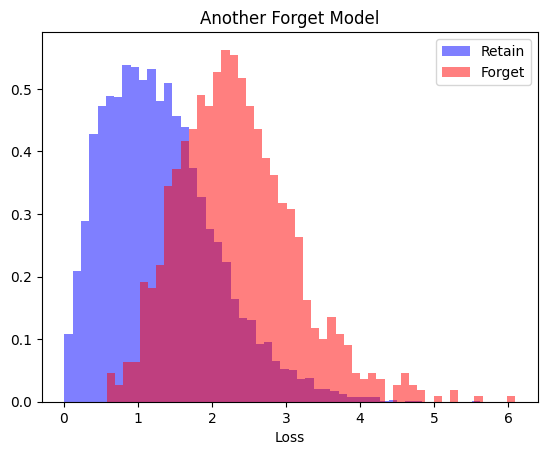

In [43]:
plt.hist(
    retain_losses_CE, density=True, bins=50, alpha=0.5, label="Retain", color="blue"
)
plt.hist(
    forget_losses_CE, density=True, bins=50, alpha=0.5, label="Forget", color="red"
)
plt.title("Another Forget Model")
plt.xlabel("Loss")
plt.legend()
plt.show()

In [44]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(
    retain_losses_CE, len(forget_losses), replace=False
)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(
    -1, 1
)
members_mia = np.concatenate(
    [np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))]
)

scores_another_forget = simple_mia(samples_mia, members_mia)
print(
    f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}"
)

Another Forget Model MIA score with Cross Entropy losses: 0.7465


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

In [162]:
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import (
    sequential_to_arch,
    arch_to_graph,
    graph_to_arch,
    arch_to_sequential,
)
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("checkpoint/best_model.pth")
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u=torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

/tmp/ipykernel_63329/1323383109.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/best_model.pth")


DataBatch(x=[216, 3], edge_index=[2, 59050], edge_attr=[59050, 6], u=[1, 8], batch=[216], ptr=[2])


In [163]:
class GraphMetaNetwork(nn.Module):
    """
    Wrapper class for the graph metanetwork
    """

    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.u,
            data.batch,
        )
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr


# Define the encoder and MPNN
pre_embedding_dim = 64
global_in_dim = 8
hidden_dim = 32
node_out_dim = 3
edge_out_dim = 1
global_out_dim = 8
num_gnn_layers = 4
encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(
    node_in_dim=pre_embedding_dim,
    edge_in_dim=pre_embedding_dim,
    global_in_dim=global_in_dim,
    hidden_dim=hidden_dim,
    node_out_dim=node_out_dim,
    edge_out_dim=edge_out_dim,
    global_out_dim=global_out_dim,
    num_layers=num_gnn_layers,
    reduce="mean",
)

# Create the metanetwork
gmn = GraphMetaNetwork(encoder, mpnn)
gmn.to(device)

GraphMetaNetwork(
  (encoder): NodeEdgeFeatEncoder(
    (node_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (neuron_num_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (node_type_encoder): Embedding(17, 64)
    (x_proj): Linear(in_features=192, out_features=64, bias=True)
    (weight_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (conv_pos_encoder): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_type_encoder): Embedding(14, 64)
    (edge_attr_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): S

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

In [164]:
"""
Add your code below
"""

"""
In short, our idea is:

1. We have a pre-trained model that we want to unlearn.
2. We convert the model into a graph representation.
3. We feed the graph representation to the GMNN.
4. The GMNN predicts the new parameter graph of the unlearned model.
5. We convert the predicted graph back to the model.
6. We measure KL-divergence between model predictions and the uniform distribution on the forget set.
7. We train the GMNN to provide parameters that minimize the KL-divergence.
"""

weights = torch.load("checkpoint/trained_model.pth")
model = create_model()
model.load_state_dict(weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now, we want to obtain 10 slightly different models in order to prevent overfitting


def obtain_model_set(model, num_models=10):
    """
    Function to obtain a set of models with slightly different parameters,
    we perform a single step of gradient descent on the model
    """

    model_set = []

    classification_criterion = nn.CrossEntropyLoss()

    for _ in range(num_models):
        # Create a new model
        new_model = create_model()
        new_model.load_state_dict(model.state_dict())
        new_model.to(device)

        # Define the optimizer
        optimizer = torch.optim.AdamW(new_model.parameters(), lr=1e-2, amsgrad=True)

        # Perform a single step of gradient descent
        new_model.train()
        for data, targets in retain_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = new_model(data)
            loss = classification_criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        optimizer.zero_grad()  # clear the gradients, lowers memory peak

        print(f"Model {len(model_set)+1} trained")

        model_set.append(new_model)

    return model_set


model_set = obtain_model_set(model, num_models=10)

/tmp/ipykernel_63329/1187309553.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/trained_model.pth")


Model 1 trained
Model 2 trained
Model 3 trained
Model 4 trained
Model 5 trained
Model 6 trained
Model 7 trained
Model 8 trained
Model 9 trained
Model 10 trained


In [165]:
def model_to_graph(model):
    """
    Function to convert a model to a graph
    """

    arch = sequential_to_arch(model)
    x, edge_index, edge_attr = arch_to_graph(arch)
    x = x.float()
    edge_attr = edge_attr.float()

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u=torch.zeros(1, 8))

In [166]:
class CifarClassifier(nn.Module):
    """
    Wrapper class for the CIFAR classifier returned by create_model
    """

    def __init__(self):
        super(CifarClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.model(x)


def graph_out_to_module(out):
    """
    Function to convert the output of the GMN to a module
    """

    model_reconverted = graph_to_arch(sequential_to_arch(create_model()), out)
    model_reconverted = arch_to_sequential(model_reconverted, create_model())
    model_reconverted

    return model_reconverted

In [167]:
# GMNN training

BATCH_SIZE = 2
EPOCHS = 10

assert len(model_set) % BATCH_SIZE == 0
assert BATCH_SIZE > 1, "Batch size must be greater than 1 for training with GMN"

model_graphs = [model_to_graph(model) for model in model_set]
batches = [
    Batch.from_data_list(model_graphs[i : i + BATCH_SIZE])
    for i in range(0, len(model_graphs), BATCH_SIZE)
]  # batches of 2 models

model_graphs_train = batches[: int(len(batches) * 0.8)]
model_graphs_val = batches[int(len(batches) * 0.8) :]

print(f"Number of models: {len(model_graphs)}")
print(f"Number of training models: {len(model_graphs_train * BATCH_SIZE)}")
print(f"Number of validation models: {len(model_graphs_val * BATCH_SIZE)}")


def train_gmn_generalized(
    gmn,
    model_graphs_train,
    model_graphs_val,
    forget_loader,
    forget_loader_val,
    meta_optimizer: torch.optim.Optimizer,
    criterion,
    epochs=10,
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gmn.to(device)
    gmn.train()

    train_losses = [
        {
            "model": i,
            "losses": [],
        }
        for i in range(len(model_graphs_train * BATCH_SIZE))
    ]
    val_losses = [
        {
            "model": i,
            "losses": [],
        }
        for i in range(len(model_graphs_val * BATCH_SIZE))
    ]

    print("Loss dict: ", train_losses)
    print("Loss dict: ", val_losses)

    for epoch in range(epochs):

        # Training
        gmn.train()

        for i, batch in enumerate(
            tqdm(
                model_graphs_train,
                desc=f"Epoch {epoch+1}/{epochs}, Training",
                leave=False,
            )
        ):
            meta_optimizer.zero_grad()
            # obtained unlearned model from meta-network
            batch.to(device)
            _, models, _, _ = gmn(batch)
            # convert the output of the GMN to a module
            models = models.view(BATCH_SIZE, -1, 1)  # last 1 is the feature dimension

            meta_optimizer.zero_grad(set_to_none=True)

            for j, model in enumerate(models):
                model = graph_out_to_module(model)
                model.to(device)

                # use model on forget data to obtain gradients for meta-network
                batch_loss = 0
                for data, targets in forget_loader:
                    data, targets = data.to(device), targets.to(device)

                    outputs = model(data)
                    loss = criterion(
                        F.log_softmax(outputs, dim=1), make_target(targets)
                    )

                    loss.backward()
                    batch_loss += loss.item()

                meta_optimizer.step()
                train_losses[i * BATCH_SIZE + j]["losses"].append(batch_loss)

        # Validation
        gmn.eval()

        with torch.no_grad():
            for batch in model_graphs_val:
                batch.to(device)
                models = gmn(batch)
                models = models.view(BATCH_SIZE, -1, 1)

                for i, model in enumerate(models):
                    model = graph_out_to_module(model)
                    model.to(device)

                    batch_loss = 0
                    for data, targets in forget_loader_val:
                        data, targets = data.to(device), targets.to(device)

                        outputs = model(data)
                        loss = criterion(
                            F.log_softmax(outputs, dim=1), make_target(targets)
                        )

                        batch_loss += loss.item()

                    val_losses[i]["losses"].append(batch_loss)

        mean_train_losses = [np.mean(loss["losses"]) for loss in train_losses]
        mean_val_losses = [np.mean(loss["losses"]) for loss in val_losses]

        print(
            f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_train_losses}, Validation Loss: {mean_val_losses}"
        )

    return gmn, train_losses, val_losses

Number of models: 10
Number of training models: 8
Number of validation models: 2


In [ ]:
# flush CUDA memory
torch.cuda.empty_cache()

import gc

gc.collect()

trained_gmn, losses_train, losses_val = train_gmn_generalized(
    gmn=gmn,
    model_graphs_train=model_graphs_train,
    model_graphs_val=model_graphs_val,
    forget_loader=forget_loader,
    forget_loader_val=forget_loader_val,
    meta_optimizer=torch.optim.Adam(gmn.parameters(), lr=1e-4),
    criterion=nn.KLDivLoss(reduction="batchmean"),
    epochs=EPOCHS,
)

# clearly fails due to non-differentiability of the model_arch_graph.py functions
# we need a method that can incorporate a non-differentiable graph-to-network transition for downstream tasks

Loss dict:  [{'model': 0, 'losses': []}, {'model': 1, 'losses': []}, {'model': 2, 'losses': []}, {'model': 3, 'losses': []}, {'model': 4, 'losses': []}, {'model': 5, 'losses': []}, {'model': 6, 'losses': []}, {'model': 7, 'losses': []}]
Loss dict:  [{'model': 0, 'losses': []}, {'model': 1, 'losses': []}]


ValueError: too many values to unpack (expected 4)

In [168]:
# flush CUDA memory
torch.cuda.empty_cache()

import gc

gc.collect()

980

In [183]:
from typing import List, Callable


def train_gmn_mock_optimizer(
    gmn,
    model_graphs_train,
    model_graphs_val,
    forget_loader,
    forget_loader_val,
    meta_optimizer: torch.optim.Optimizer,
    downstream_optimizer_factory: Callable[[nn.Module], torch.optim.Optimizer],
    downstream_criterion,
    meta_norm,
    epochs=10,
):

    import torchviz

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gmn.to(device)
    gmn.train()

    train_losses_meta = []
    train_losses_downstream = [
        {
            "model": i,
            "losses": [],
        }
        for i in range(len(model_graphs_train * BATCH_SIZE))
    ]
    val_losses_meta = []
    val_losses_downstream = [
        {
            "model": i,
            "losses": [],
        }
        for i in range(len(model_graphs_val * BATCH_SIZE))
    ]

    for epoch in range(epochs):

        # Training
        gmn.train()

        for i, batch in enumerate(
            tqdm(
                model_graphs_train,
                desc=f"Epoch {epoch+1}/{epochs}, Training",
                leave=False,
            )
        ):
            # obtained unlearned model from meta-network
            batch.to(device).detach().requires_grad_(True)
            models = gmn(batch)
            # convert the output of the GMN to a module
            models = models.view(BATCH_SIZE, -1, 1)  # last 1 is the feature dimension

            out_models = torch.empty((BATCH_SIZE, models.size(1), 1), device=device)

            for j, model in enumerate(models):

                model_original = model.clone().detach()

                model = graph_out_to_module(model_original)  # gradients are lost here
                model.to(device, non_blocking=True)

                opt = downstream_optimizer_factory(model)

                # train model on downstream task to further modify the model in the direction of unlearning
                batch_loss = 0
                for data, targets in forget_loader:
                    data, targets = data.to(device, non_blocking=True), targets.to(
                        device
                    )

                    outputs = model(data)
                    loss = downstream_criterion(
                        F.log_softmax(outputs, dim=1), make_target(targets)
                    )

                    opt.zero_grad()

                    loss.backward()
                    opt.step()
                    batch_loss += loss.item()

                    opt.zero_grad()  # just to be sure, our training procedure is *weird*

                batch_loss /= len(forget_loader)
                # obtain meta-loss as the difference between trained model weights and the output of the GMN

                graph_trained = model_to_graph(model)
                # extract_params
                new_params = graph_trained.edge_attr[:, 0].view(-1, 1).to(device)

                out_models[j] = new_params
                train_losses_downstream[i * BATCH_SIZE + j]["losses"].append(batch_loss)

            # make it so out_models is like a constant to autograd
            out_models = out_models.detach()
            meta_loss = meta_norm(models, out_models)

            meta_optimizer.zero_grad()
            meta_loss.backward()
            meta_optimizer.step()

            train_losses_meta.append(meta_loss.item())

        mean_train_losses = np.mean(
            [np.mean(loss["losses"]) for loss in train_losses_downstream]
        )

        print(
            f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_train_losses}, Meta Loss: {np.mean(train_losses_meta)}"
        )

        # Validation
        gmn.eval()

        with torch.no_grad():

            for i, batch in enumerate(model_graphs_val):
                batch.to(device)
                models = gmn(batch)
                models = models.view(BATCH_SIZE, -1, 1)

                out_models = torch.empty((BATCH_SIZE, models.size(1), 1), device=device)

                for j, model in enumerate(models):
                    model_original = model.clone().detach()

                    model = graph_out_to_module(model_original)
                    model.to(device)
                    model.eval()

                    batch_loss = 0
                    for data, targets in forget_loader_val:
                        # use different data cause why not, but we must train this network
                        # to validate the meta-network
                        data, targets = data.to(device), targets.to(device)

                        outputs = model(data)
                        loss = downstream_criterion(
                            F.log_softmax(outputs, dim=1), make_target(targets)
                        )

                        batch_loss += loss.item()

                    batch_loss /= len(forget_loader_val)
                    graph_trained = model_to_graph(model)
                    new_params = graph_trained.edge_attr[:, 0].view(-1, 1).to(device)

                    out_models[j] = new_params

                    val_losses_downstream[i * BATCH_SIZE + j]["losses"].append(
                        batch_loss
                    )

                out_models = out_models.detach()
                meta_loss = meta_norm(models, out_models)
                val_losses_meta.append(meta_loss.item())

        mean_val_losses = np.mean(
            [np.mean(loss["losses"]) for loss in val_losses_downstream]
        )

        print(
            f"Epoch {epoch+1}/{epochs}, Validation Loss: {mean_val_losses}, Meta Loss: {np.mean(val_losses_meta)}"
        )

    return (
        gmn,
        train_losses_downstream,
        val_losses_downstream,
        train_losses_meta,
        val_losses_meta,
    )


def create_optimizer(model, lr=1e-4):
    """
    Function to create an optimizer for the model
    """
    return torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)

In [170]:
torch.autograd.set_detect_anomaly(True)

(
    gmn,
    train_losses_downstream,
    val_losses_downstream,
    train_losses_meta,
    val_losses_meta,
) = train_gmn_mock_optimizer(
    gmn=gmn,
    model_graphs_train=model_graphs_train,
    model_graphs_val=model_graphs_val,
    forget_loader=forget_loader,
    forget_loader_val=forget_loader_val,
    meta_optimizer=create_optimizer(gmn),
    downstream_optimizer_factory=create_optimizer,
    downstream_criterion=nn.KLDivLoss(reduction="batchmean"),
    meta_norm=F.huber_loss,
    epochs=EPOCHS,
)

Epoch 1/10, Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 2.893961289059371, Meta Loss: 3.999264349546783e-08
Epoch 1/10, Validation Loss: 1.7061828998521378e-06, Meta Loss: 0.0


Epoch 2/10, Training Loss: 1.4773927269736304, Meta Loss: 2.0045022499498577e-08
Epoch 2/10, Validation Loss: 3.2467227981669566e-06, Meta Loss: 0.0


Epoch 3/10, Training Loss: 0.9989720781954625, Meta Loss: 1.3395904623995461e-08
Epoch 3/10, Validation Loss: 5.431506813617186e-05, Meta Loss: 0.0


Epoch 4/10, Training Loss: 0.7619569517322815, Meta Loss: 1.0071350642348875e-08
Epoch 4/10, Validation Loss: 0.0022629238853681954, Meta Loss: 0.0


Epoch 5/10, Training Loss: 0.6181830634456128, Meta Loss: 8.076297465173244e-09
Epoch 5/10, Validation Loss: 0.022098557293600152, Meta Loss: 0.0


Epoch 6/10, Training Loss: 0.5196682075814655, Meta Loss: 6.74581883177335e-09
Epoch 6/10, Validation Loss: 0.02651298419898277, Meta Loss: 0.0


Epoch 7/10, Training Loss: 0.4483915851717549, Meta Loss: 5.7953823620020865e-09
Epoch 7/10, Validation Loss: 0.02321704795796872, Meta Loss: 0.0


Epoch 8/10, Training Loss: 0.3944896789093036, Meta Loss: 5.082411286315772e-09
Epoch 8/10, Validation Loss: 0.02149893060629182, Meta Loss: 0.0


Epoch 9/10, Training Loss: 0.3520174999022856, Meta Loss: 4.5277448719306514e-09
Epoch 9/10, Validation Loss: 0.021962341252920698, Meta Loss: 0.0


Epoch 10/10, Training Loss: 0.31783909877645783, Meta Loss: 4.083874838821389e-09
Epoch 10/10, Validation Loss: 0.025297748782298866, Meta Loss: 0.0


#### Post-training: Unlearning a model with GMN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4653468..2.0708318].


Random model: 430


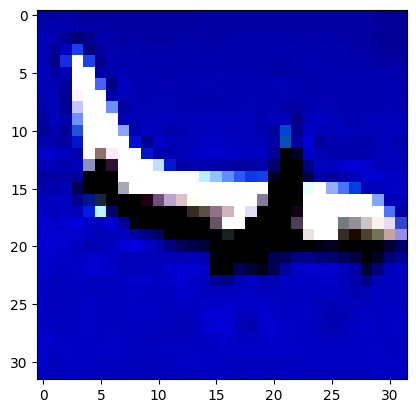

In [171]:
import random

random_num = random.randint(0, len(forget_loader_val.dataset))
print(f"Random model: {random_num}")
airplane_sample, _ = forget_loader_val.dataset[random_num]
airplane_sample = airplane_sample.to(device)
# show  in BGR
plt.imshow(airplane_sample.permute(1, 2, 0).cpu().numpy())
plt.show()

In [172]:
weights = torch.load("checkpoint/trained_model.pth")
model = create_model()
model.load_state_dict(weights)
model.eval().to(device)

# get the output of the model
model_output = model(airplane_sample.unsqueeze(0).to(device))

/tmp/ipykernel_63329/3587710113.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/trained_model.pth")


In [173]:
model_output.shape

torch.Size([1, 10])

For most random inputs, the distribution down here will clearly show a preference for 0 (Airplane)

In [174]:
model_output = F.softmax(model_output, dim=1)
print(model_output)
predicted_class = torch.argmax(model_output, dim=1).item()
print(f"Predicted class: {predicted_class}")

tensor([[0.6865, 0.0044, 0.0964, 0.0073, 0.0120, 0.0041, 0.0022, 0.0010, 0.1853,
         0.0007]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class: 0


In [175]:
input_graph = model_to_graph(model)
input_batch = Batch.from_data_list([input_graph]).to(device)

gmn.eval()
with torch.no_grad():
    output_graph = gmn(input_batch)

    out_model = graph_out_to_module(output_graph)

In [176]:
out_model.to(device)
out_model_output = out_model(airplane_sample.unsqueeze(0).to(device))

The unlearned distribution here should be *almost* uniform, with a slight preference for some classes. This is because the GMN is not perfect, and it is not guaranteed that the model will forget the class completely. However, the distribution should be significantly different from the original one.

In [177]:
out_distribution = F.softmax(out_model_output, dim=1)
out_predicted_class = torch.argmax(out_distribution, dim=1).item()
print(f"Predicted class: {out_predicted_class}")
print(out_distribution)

Predicted class: 7
tensor([[0.0665, 0.0576, 0.0803, 0.1137, 0.0931, 0.0820, 0.1330, 0.1707, 0.1357,
         0.0674]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [178]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(
    train_losses_downstream + val_losses_downstream,
    columns=["model", "losses"],
)

In [179]:
df.iloc[: len(train_losses_downstream), 0] = "train"
df.iloc[len(train_losses_downstream) :, 0] = "val"
df["index"] = df.index

/tmp/ipykernel_63329/2888028891.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'train' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[: len(train_losses_downstream), 0] = "train"


In [180]:
df.reset_index(drop=True, inplace=True)
df

,model,losses,index
0,train,"[0.8243633151054383, 0.09068160206079483, 0.04...",0
1,train,"[0.9352982461452484, 0.08672427982091904, 0.03...",1
2,train,"[20.437099075317384, 0.0642934113740921, 0.035...",2
3,train,"[0.3323924332857132, 0.06388577967882156, 0.04...",3
4,train,"[0.19092334657907487, 0.049803464114665984, 0....",4
5,train,"[0.19433929920196533, 0.050828490778803824, 0....",5
6,train,"[0.12088969200849534, 0.040527984499931335, 0....",6
7,train,"[0.11638490483164787, 0.03984830677509308, 0.0...",7
8,val,"[1.654028835673671e-06, 4.786747922480572e-06,...",8
9,val,"[1.7583369640306046e-06, 4.787777470482979e-06...",9


In [181]:
# explode the losses list
df = df.explode("losses")
df["epoch"] = df.groupby("index").cumcount()

<Axes: xlabel='epoch', ylabel='losses'>

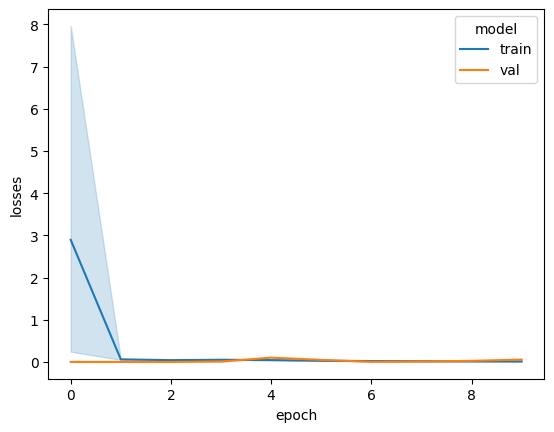

In [182]:
sns.lineplot(data=df, x="epoch", y="losses", hue="model")

## Report

...